# Naming convention


[b/l/t][h/c/l]

b = benchmark, l = listing, t = transaction
h = hdb, c = condo, l = landed

# Setup

In [3]:

'''
This script writes the 2019 Carousell HDB average regional/zonal single room rental rates into DB.
We then adjust the rates to the current year using the rental index. This is done all via SQL scripts.
Then, it returns dfs of the listing/transactions (dw_listing_id and dw_transaction_id as the unique identifiers) and a binary
variable representing the outcome: 1 for single room rental, 0 for not.
'''


import pandas as pd
import os
import config as config
from rea_python.main.database import DBCopyMode, RedshiftHook
from rea_python.constants import OutputFormat


sql_path = os.path.join(os.path.dirname(os.path.realpath('rental_type.ipynb')), 'sql')

# initialize redshift hook
src_hook = RedshiftHook(iam_role_arn=config.IAM_ROLE_ARN,
                        via_s3_bucket=config.REDSHIFT_HOOK_BRIDGE_BUCKET,
                        via_s3_folder=config.REDSHIFT_HOOK_BRIDGE_FOLDER)

# set up connection
src_hook.set_conn_from_uri(config.DATA_WAREHOUSE_URI)
# load queries from sql
src_hook.load_queries_from_folders([sql_path])


#b - benchmark, h - hdb
bh = os.path.join(os.path.join(os.path.dirname(os.path.dirname(os.path.realpath('rental_type.ipynb'))),'input'),'hdb_avg_single_room_rental.csv')
bh = pd.read_csv(bh)

#write the 2019 Carousell average HDB single room rental rates into the DB.
src_hook.copy_from_df(df=bh, target_table='data_science.sg_project_hdb_rental_rates', mode=DBCopyMode.DROP)

def query(query_str, template_parameters=None):
    return src_hook.execute_loaded_query(query_name=query_str, output_format=OutputFormat.pandas, template_parameters=template_parameters)

def save_adjusted_rental_rates(template_parameters):
    '''
    Execute adjusted_rental_rates query, store it into a df, and then put this df into the table. This is only for HDB.
    transaction_year : int. A year, aka 2021. You want the latest year you are in.
    buffer: int. Amount in dollars you add to the average single room rental rate, to form your upper bound. So anything within this bound is considered a single room rental.
    '''
    arr = query('adjusted_rental_rates', template_parameters)
    src_hook.copy_from_df(df=arr, target_table='data_science.sg_project_adjusted_rental_rates', mode=DBCopyMode.DROP)


save_adjusted_rental_rates({"transaction_year":2021,"buffer":100})
transaction_hdb = query('transaction_hdb')
listings_hdb = query('listings_hdb')
listings_condo = query('listings_condo', {"floor_area_in_sqm":30 , "pps_percentile":0.1 , "listing_price":1800})
listings_landed = query('listings_landed', {"floor_area_in_sqm":30 , "pps_percentile":0.1 , "listing_price":1800})


2021-08-18 14:12:05,179 : rea_python.main.database.RedshiftHook : WARNING : S3 configuration is needed for any bulk write operation. 
Instantiating S3 hooks for bucket dev-misc-usage, please check you have valid AWS credentials access in the `~/.aws/credentials` file.
IAM role ARN is provided. 
2021-08-18 14:12:05,192 : rea_python.main.database.RedshiftHook : INFO : Connection established on host luna.cdxepk94qslx.ap-southeast-1.redshift.amazonaws.com
2021-08-18 14:12:05,192 : rea_python.main.database.RedshiftHook : WARNING : 5 loaded queries detected into database hook from folder ['C:\\Users\\RyanChew\\Desktop\\rea\\RentalType\\src\\sql']. 
2021-08-18 14:12:05,203 : rea_python.main.database.RedshiftHook : WARNING : DDL is provided. Going to initialise the table - data_science.sg_project_hdb_rental_rates. 
2021-08-18 14:12:05,204 : rea_python.main.database.RedshiftHook : WARNING : Executing the Drop - Recreate statement. 
2021-08-18 14:12:05,204 : rea_python.main.database.RedshiftHook

In [16]:
pairing = ['dw_listing_id','property_type','single_room_rental']
overall = [listings_hdb[pairing], listings_condo[pairing], listings_landed[pairing]]
result = pd.concat(overall)

#drop arr
# src_hook.execute_raw_query(query = 'DROP TABLE IF EXISTS data_science.sg_project_adjusted_rental_rates')

print("Finished")

KeyError: "['property_type'] not in index"

In [10]:
result

dw_listing_id  single_room_rental
0     79954fe570082d897479eb4cb3fa5281                   0
1     e020cf8d85bdc0ea8ef406304a2cef3c                   0
2     bd70feb3cbeee1a0c5ec04ef175dada1                   0
3     429a7a0d115d146f3e8d6bb0f4853a24                   0
4     5984bce48c3b093bf192981ef92ff526                   0
...                                ...                 ...
1367  757e8b6270b1ed21f675b55c92336b8b                   0
1368  aa893657b14f89cf6e314a5904555291                   1
1369  860e120d04e8beb93f215113715e6031                   1
1370  a65be15248cfadbfc0885676b52b03ed                   1
1371  c16bbaaaa060e023d941567bc4bbd663                   0

[137296 rows x 2 columns]

In [6]:
listings_hdb

zone postal_code                     dw_listing_id  \
0        toa payoh      310246  fff66c9da22a4456e24bdb53283db9a5   
1      bukit merah      080105  0840e181b3bc14cf68c5f28031658ef3   
2       queenstown      130022  67554b7e4af9c96f9f1821d2073bed98   
3       queenstown      130022  3570c6e98ec57941dc090dfb2f1e1759   
4       queenstown      140050  aaa4ce2276be252786f6fa4604cf9fbd   
...            ...         ...                               ...   
41756    toa payoh      310179  5bb106e3e5afcb8253c62dcf035fc8e8   
41757      geylang      370046  6de50842a7616ebe05b0520d7c9b9774   
41758      geylang      370046  eb1e1803a4acc90e955bd2cb4016b9b7   
41759     tampines      524497  28d655c385a96d607d2bcd5dbcbad07f   
41760     tampines      524497  631bf20e6c3b9f09beb815928a0ee752   

                         dw_property_id  listing_price  \
0      9506ab1f1aecafbd34fbfdbf97b31092           2750   
1      34e42f1a3e93d1593b41285772d7869f           3200   
2      003826f2a3f5367cee36e65fb8789901            750   
3      003826f2a3f5367cee36e65fb8789901            800   
4      f948a1327af3dec4a9949c176574f3fa           3200   
...                                 ...            ...   
41756  c029156d7af636209c0f46fc3de3dede           3000   
41757  9a0e0e49115ee7b6b1a46495d08cd804            800   
41758  9a0e0e49115ee7b6b1a46495d08cd804            800   
41759  7d29ce2c7097493c57bd2ae7f6b67009           2700   
41760  d71a5a2318b0feabb6c75a58e5169edd           2400   

       listing_price_threshold  single_room_rental  
0                       1122.6                   0  
1                       1268.7                   0  
2                       1268.7                   1  
3                       1268.7                   1  
4                       1268.7                   0  
...                        ...                 ...  
41756                   1122.6                   0  
41757                   1133.0                   1  
41758                   1133.0                   1  
41759                   1001.0                   0  
41760                   1001.0                   0  

[41761 rows x 7 columns]

# Distributions

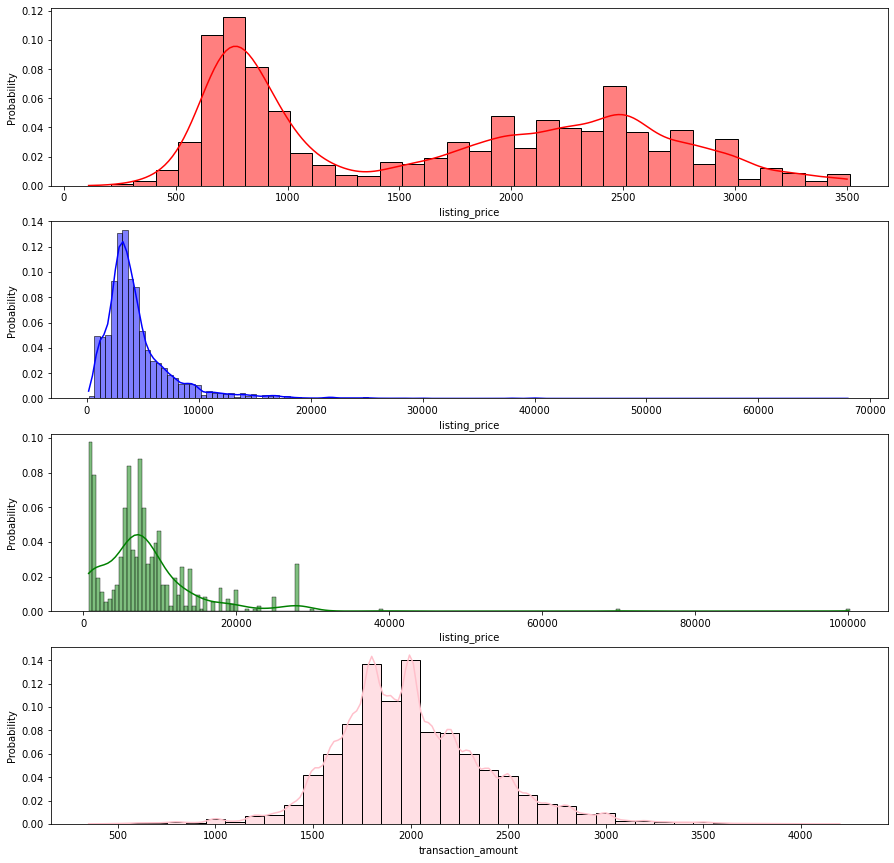

In [65]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize=(15,15))
sns.histplot(lh, x='listing_price', stat='probability', kde='1',binwidth=100,color='red', ax=ax1)
sns.histplot(lc, x='listing_price', stat='probability', kde='1',binwidth=500,color='blue', ax=ax2)
sns.histplot(ll, x='listing_price', stat='probability', kde='1',binwidth=500,color='green', ax=ax3)
sns.histplot(th, x='transaction_amount', stat='probability', kde='1',binwidth=100,color='pink', ax=ax4)
